In [1]:
%pylab inline
from pandas.io import gbq
import pandas as pd
import numpy as np
import scipy as sp
import random 
import math
pd.set_option('display.max_columns', 500) #show more columns
pd.set_option('display.width', 1000)
import cPickle 
import os

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale, normalize
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import metrics 

from scipy import stats

import re 
from time import time
import json

import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Delivery Service Data Analysis

### Bruno Wu

## Read data and clean up
- The data is read into a Python Pandas dataframe
- Some clean up is needed to get the correct regions/cities
- Turns out there are 3 unique cities in this dataset

In [2]:
#Read in file
df = pd.read_csv('delivery_data.csv')

#Clean 'sf' and 'sf '
df['region'] = df.region.str.replace('sf ', 'sf')

cities_list = unique(df.region)
print cities_list

['chi' 'nyc' 'sf']


## Convert UTC to local time for each city

- By converting UTC time to local time, we have an "apples-to-apples" comparison across cities in terms of their hours of operation. 
- This allows us to compare across cities at local times and come up with insights on when to staff the Customer Support Team for each city.

In [3]:
#Switch from UTC to Local Times
from datetime import datetime
from dateutil import tz

from_zone = tz.gettz('UTC')
to_nyc_zone = tz.gettz('America/New_York')
to_chi_zone = tz.gettz('America/Chicago')
to_sf_zone = tz.gettz('America/Los_Angeles')

# df['time'] = df['time'].map(lambda x: re.sub('UTC', '', x))
# df['time'] = df['time'].map(lambda x: re.sub('+0000', '', x))

# df.time = df.time.replace(' +0000', '')
# df.time = df.time.str.replace('UTC', '')
# df.time = df.time.map(lambda x: pd.to_datetime(x))
df.time = df.time.map(lambda x: str(pd.to_datetime(x)))

df.loc[df.region == 'chi', 'time'] = df[df.region == 'chi']['time'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').replace(tzinfo=from_zone).astimezone(to_chi_zone))
df.loc[df.region == 'nyc', 'time'] = df[df.region == 'nyc']['time'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').replace(tzinfo=from_zone).astimezone(to_nyc_zone))
df.loc[df.region == 'sf', 'time'] = df[df.region == 'sf']['time'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').replace(tzinfo=from_zone).astimezone(to_sf_zone))

In [4]:
df.head()

,time,id,rating,issue,region
0,2014-06-01 23:23:16-05:00,233599337,5,NaN,chi
1,2014-06-01 22:57:50-05:00,233599376,5,NaN,chi
2,2014-06-01 21:52:38-05:00,233599328,5,NaN,chi
3,2014-06-01 21:52:04-05:00,233599070,5,NaN,chi
4,2014-06-01 21:41:43-05:00,233599100,5,NaN,chi


## Initial count of data

- Adding an "hour" column would make it easier to aggregate and compare by hours of operation later (first table below).
- Second table below shows the total number of order deliveries at each city.

In [606]:
df['hour'] = df['time'].map(lambda x: pd.to_datetime(x).hour)
df.head()

,time,id,rating,issue,region,hour
0,2014-06-01 23:23:16-05:00,233599337,5,NaN,chi,23
1,2014-06-01 22:57:50-05:00,233599376,5,NaN,chi,22
2,2014-06-01 21:52:38-05:00,233599328,5,NaN,chi,21
3,2014-06-01 21:52:04-05:00,233599070,5,NaN,chi,21
4,2014-06-01 21:41:43-05:00,233599100,5,NaN,chi,21


In [607]:
#Size of dataset by cities
[(city, len(df[df.region==city])) for city in cities_list]

[('chi', 6430), ('nyc', 1290), ('sf', 7237)]

In [608]:
df.groupby('region').agg(['count'])['id']

,count
region,
chi,6430
nyc,1290
sf,7237


In [609]:
df.groupby('region').agg(['count'])['issue']

,count
region,
chi,272
nyc,122
sf,693


## Percentage of orders where customer reported an issue (by region)

- Below are the percentages of orders in which users reported an issue.


- Chicago did the best in terms of fewest % of issues reported by users.
    - NYC and SF both have more than the DOUBLE the incidence of customer reported issues.

In [433]:
df.groupby('region').agg(['count'])['issue'] * 100 / df.groupby('region').agg(['count'])['id']

,count
region,
chi,4.230171
nyc,9.457364
sf,9.575791


In [423]:
print ''
print sum(df.groupby('id').agg(['count'])['time'] > 2)*1.0 / len(unique(df['id']))

count    0.009823
dtype: float64

## Customer ratings breakdown by region

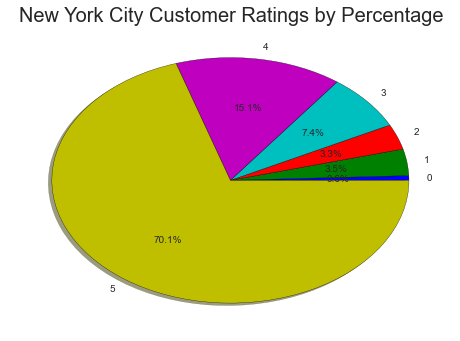

In [541]:
plt.title("New York City Customer Ratings by Percentage", fontsize=20)
labels = [str(num) for num in xrange(6)]
fracs = [item for sublist in df[df.region=='nyc'].groupby('rating').agg(['count'])['id'].values for item in sublist]
plt.pie(fracs, labels=labels, autopct='%1.1f%%', shadow=True)
plt.show()

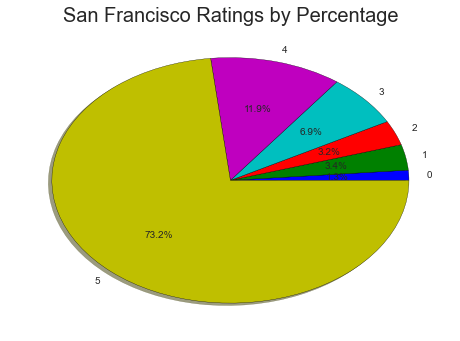

In [542]:
plt.title("San Francisco Ratings by Percentage", fontsize=20)
labels = [str(num) for num in xrange(6)]
fracs = [item for sublist in df[df.region=='sf'].groupby('rating').agg(['count'])['id'].values for item in sublist]
plt.pie(fracs, labels=labels, autopct='%1.1f%%', shadow=True)
plt.show()

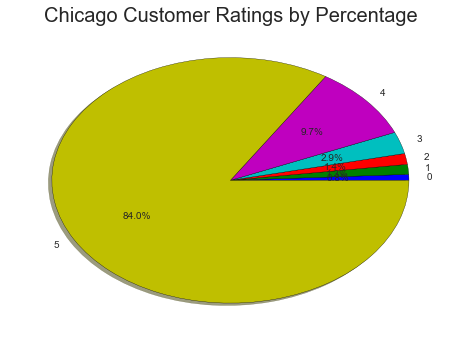

In [543]:
plt.title("Chicago Customer Ratings by Percentage", fontsize=20)
labels = [str(num) for num in xrange(6)]
fracs = [item for sublist in df[df.region=='chi'].groupby('rating').agg(['count'])['id'].values for item in sublist]
plt.pie(fracs, labels=labels, autopct='%1.1f%%', shadow=True)
plt.show()

## Overall customer satisfaction by region
- Chicago leads all three cities in terms of the fewest percentage of customer issues and the highest percentage of 5-stars ratings.
    - This suggests an inverse relationship between the incidence of issues reported and customer rating (will revisit this later).
- Mean rating for each city is shown below. As expected, Chicago has the highest average customer rating.
    - Below are calculations to determine wether the difference in average customer rating between Chi/NYC and Chi/SF are statistically significant. The p-values are extremely low for both: Chicago's higher avg customer rating is statistically significant.
- In order to assess / improve the business, it might be worthwhile to investigate what Chicago is doing differently in order to gain some insights.

In [594]:
rating = dict()
for city in cities_list:
    print 'Mean customer rating for', city, ":", sum([count * rating for count, rating in enumerate(df[df.region==city].groupby('rating').agg('count')['id'])])*1.0/len(df[df.region==city])

Mean customer rating for chi : 4.71181959565
Mean customer rating for nyc : 4.43100775194
Mean customer rating for sf : 4.44438303164


In [595]:
from scipy.stats import ttest_ind
print ttest_ind(df[df.region=='chi']['rating'], df[df.region=='nyc']['rating'])
print ttest_ind(df[df.region=='chi']['rating'], df[df.region=='sf']['rating'])

Ttest_indResult(statistic=10.698272389670421, pvalue=1.5900512143011007e-26)
Ttest_indResult(statistic=15.823898128844453, pvalue=6.6719742699582359e-56)


## Breakdown of customer issues reported by region 

In [597]:
for city in cities_list:
    print "Customer issues breakdown for", city, df[df.region==city].groupby('issue').agg('count')['id'] / sum(df[df.region==city].groupby('issue').agg('count')['id'])

Customer issues breakdown for chi issue
Damaged or spoiled          0.375000
Item charged incorrectly    0.047794
Item missing                0.180147
Other Order Issue           0.025735
Poor replacement            0.014706
Poor service                0.055147
Wrong item                  0.301471
Name: id, dtype: float64
Customer issues breakdown for nyc issue
Damaged or spoiled          0.434426
Item charged incorrectly    0.024590
Item missing                0.081967
Other Order Issue           0.032787
Poor replacement            0.073770
Poor service                0.122951
Wrong item                  0.229508
Name: id, dtype: float64
Customer issues breakdown for sf issue
Damaged or spoiled          0.223665
Item charged incorrectly    0.007215
Item missing                0.171717
Other Order Issue           0.014430
Poor replacement            0.059163
Poor service                0.142857
Wrong item                  0.380952
Name: id, dtype: float64


## Types of customer issues reported by region and Customer Support staffing
- Looking at the table from the previous page, Chicago does not have a lower incidence in any type of reported issue EXCEPT in "Poor service".
    - In all the other types of issues, Chicago either has either the highest percentage or the second-highest percentage.


- It might be possible that the most commonly reported issue for all three cities, "Damaged or spoiled" items, DOES NOT significantly contribute to lower customer satisfaction. 
    - NYC has a higher prevalence of "Damaged or spoiled" item compared to San Francisco, yet NYC's average customer rating is about the same as that of SF.
    - Preventing this issue from occuring might not result in significantly higher customer satisfaction.
   
   
- The incidence of reported "Poor service" in Chicago is more than 50% LOWER than the other cities. This could be one of the keys to improving customer satisfaction for the company.
    - By honing in on the causes of "Poor service" complaints, we can figure out specifically what the Chicago team is doing well to prevent "Poor service" from being reported by customers.
    
    
- Based on this observation, it might make sense to increase the number of Customer Support staff for NYC and SF in order to actively reduce the incidence of "Poor service" reported by customers in those cities.

In [726]:
l = (df[df.region=='chi'].groupby('hour').agg(['count'])['issue'] / sum(df[df.region=='chi'].groupby('hour').agg(['count'])['issue'])).values
x = df[df.region=='chi'].groupby('hour').agg('count').index.values
y = [item for sublist in l for item in sublist]

chi_hrs = dict()
for h in range(24):
    if h in chi_hrs:
        chi_hrs[h] += 1
    else:
        chi_hrs[h] = 0
for idx, hr in enumerate(x):
    chi_hrs[hr] = y[idx]

In [727]:
l = (df[df.region=='nyc'].groupby('hour').agg(['count'])['issue'] / sum(df[df.region=='nyc'].groupby('hour').agg(['count'])['issue'])).values
x = df[df.region=='nyc'].groupby('hour').agg('count').index.values
y = [item for sublist in l for item in sublist]

nyc_hrs = dict()
for h in range(24):
    if h in nyc_hrs:
        nyc_hrs[h] += 1
    else:
        nyc_hrs[h] = 0
for idx, hr in enumerate(x):
    nyc_hrs[hr] = y[idx]

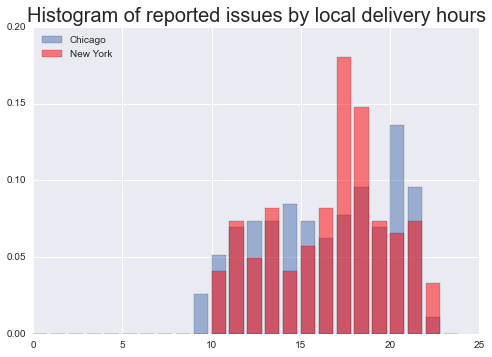

In [765]:
plt.bar(range(len(chi_hrs.values())), chi_hrs.values(), alpha=0.5, label='Chicago')
plt.bar(range(len(nyc_hrs.values())), nyc_hrs.values(), alpha=0.5, label='New York', color = "red")
plt.title("Histogram of reported issues by local delivery hours", fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Evening rush-hour deliveries and Customer Support Team staffing
- From the histogram in the previous page:
    - For NYC, a large percentage of complaints occurred within evening rush hours (~47% of complaints between 4pm and 7pm)
    - For Chicago, most of the complaints occurred outside of evening rush hours (~41% between 10am and 4pm, ~40% between 6pm and 9pm)
    
    
- Based on this observation, it might make sense to increase Customer Support staff during evening rush hours for NYC and during the non-evening rush hours for Chicago.
    
    
- Based on this observation, it might be worthwhile to test whether lowering the number of deliveries during evening rush hours (in NYC and potentially other cities as well) can help to decrease the incidence of issues reported by customer, thereby increasing customer rating. 

In [759]:
l = (df[df.region=='sf'].groupby("hour").agg(['mean'])['rating']).values
x = df[df.region=='sf'].groupby("hour").agg(['mean'])['rating'].index.values
y = [item for sublist in l for item in sublist]

sf_hrs = dict()
for h in range(24):
    if h in sf_hrs:
        sf_hrs[h] += 1
    else:
        sf_hrs[h] = 0
for idx, hr in enumerate(x):
    sf_hrs[hr] = y[idx]

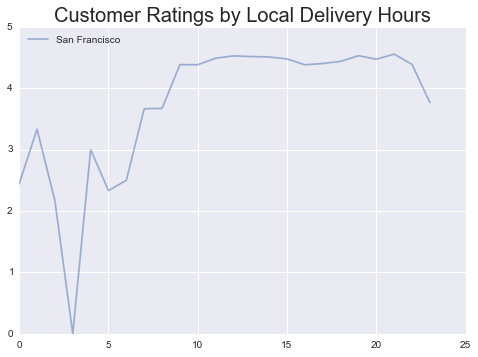

In [778]:
plt.plot(sf_hrs.values(), alpha=0.5, label='San Francisco')
plt.title("Customer Ratings by Local Delivery Hours", fontsize=20)
plt.legend(loc='upper left')
plt.show()

## The "graveyard shift": Relationship between customer rating and delivery hours

- In San Francisco, customer ratings dropped significantly for deliveries during the "graveyard shift" (between midnight and ~7am).


- There are NO deliveries (at least from the dataset) for Chicago and NYC during the graveyard shift. It would be surprising that there are customer orders during the "graveyard shift" in SF but not in Chicago or NYC. Therefore:
    - This could be due to data quality/reporting issue.
    - This could also be due to the fact that the company does not operate during these hours for Chicago and NYC.


- This noticeable difference suggests a few action steps:
    - Increase the number of Customer support staff during the graveyard shift in San Francisco in an effort to improve customer rating.
    - Calculate the cost and benefit of the company exiting the graveyard shift entirely in SF. One of the costs of operating during the graveyard shift is the Customer Support staff. If revenue is not enough to offset this and other expenses, then it might make sense not to operate during these hours to reduce the number of low customer ratings.

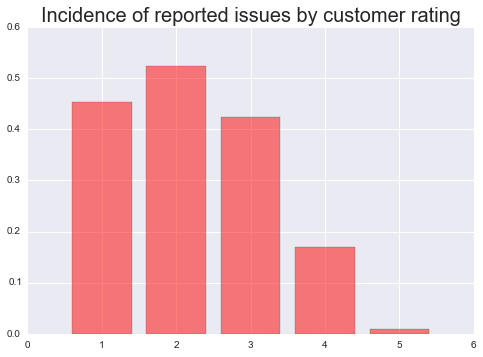

In [882]:
plt.bar(range(1,6), x, alpha=0.5, color = "red",align='center')
plt.title("Incidence of reported issues by customer rating", fontsize=20)
plt.show();

## Correlation between incidence of issues reported and customer rating

- As seen from the barchart on the previous page, as customer rating goes up, the incidence of reported issues go down (as expected).

- But does the composition of customer issues change at different customer rating level?

In [883]:
(df.groupby(['rating','issue']).agg('count')['id'] / df.groupby(['rating']).agg('count')['issue'])[2:]

rating  issue                   
1       Damaged or spoiled          0.289941
        Item charged incorrectly    0.005917
        Item missing                0.189349
        Other Order Issue           0.017751
        Poor replacement            0.088757
        Poor service                0.230769
        Wrong item                  0.177515
2       Damaged or spoiled          0.268041
        Item charged incorrectly    0.005155
        Item missing                0.211340
        Other Order Issue           0.010309
        Poor replacement            0.036082
        Poor service                0.118557
        Wrong item                  0.350515
3       Damaged or spoiled          0.313070
        Item missing                0.121581
        Other Order Issue           0.021277
        Poor replacement            0.063830
        Poor service                0.100304
        Wrong item                  0.379939
4       Damaged or spoiled          0.263158
        Item charged i

## Observations on the types of issues reported as rating changes

- As previously observed, "Poor service" could be one of the keys to reducing the incidence of total issues reported by customers.


- From the table on the previous page, the incidence of "Poor service" increases rapidly as customer rating deteriorates. 
    - This suggests that "Poor service" is a major contributor to very low customer satisfaction.


- On the otherhand, the incidence of "Wrong item" is quite high at the high range of customer rating (peaks at a rating of 4) but then decreases rapidly at the lower end of customer rating. 
    - This suggests that "Wrong item" is not a big contributor to very low customer satisfaction.
    - But reducing the incidence of "Wrong item" could be a good goal for those customers who are already quite satisfied.
    
- This suggests that Customer Support Team could be staffed by different types of personnel:
    - Those who are trained to handle "Poor service" cases for customers with very low satisfaction.  
    - Those who are trained to reduce the incidence "Wrong item" for the highly satisfied customers.
    